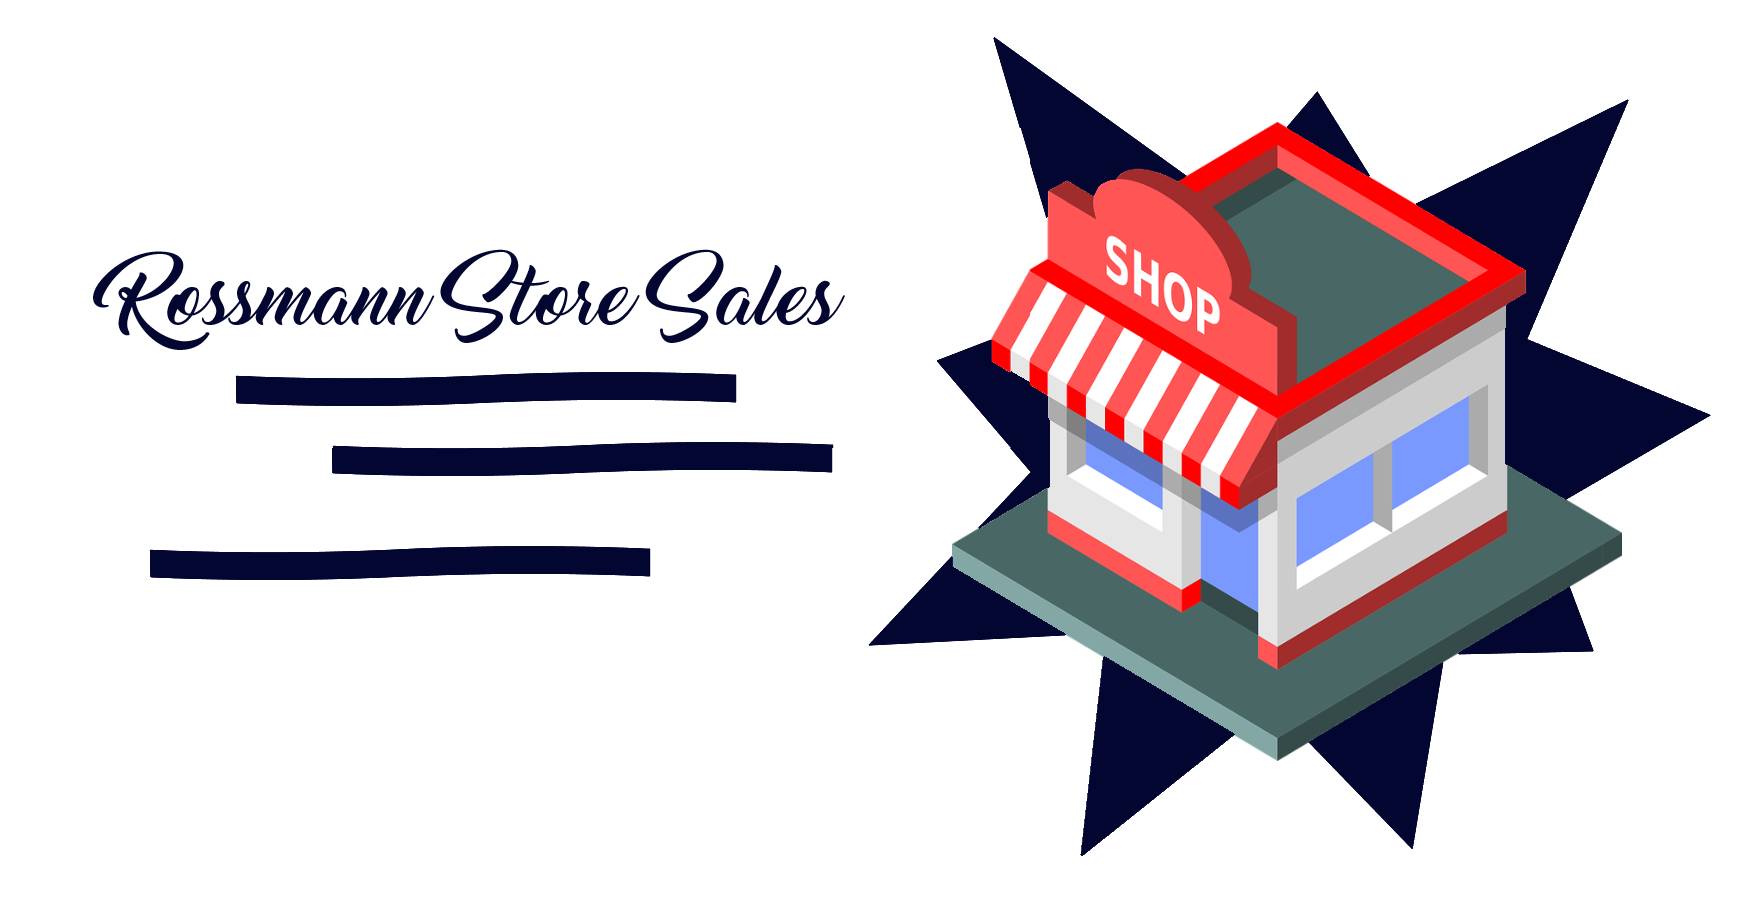

In [63]:
Image("../img/ross.png")

<p style="text-align:center;">Rossmann History.</p>
<p style="text-align:center;"><i>Rossmann are a chain of pharmacies located in Europe, mainly in Germany, with around 56,200 employees and more than 4000 stores. The company was founded by Dirk Rossmann with its headquarters in Burgwedel near Hanover in Germany.</i> ~ Wiki.</p>

Rossmann CFO on a monthly results meeting asked to all store mananger a sales forecast for the next six monsths.<br>
 - CFO Like to know next sales for start a reform of all shops.

**Pharmaceutical Bussiness Model**<br>
Rossmann is present with an e-commerce and in physical stores available for sales of household items, makeup and of course drugstore items, as it is a chain of pharmacies, it is spread over several parts of Europe, thus being able to select regions with greater growth potential and reducing the competition rate.<br> 'First Assumptions'
 - **Market Size**: All persons over 18 years of age, with preference for older persons.
 - **Marketing Channels**: Rossmann Website & Shops.
 - **Principal Metrics**: 
     - Channel Offline: Working on physical stores.
     - Recency: Purchases over time.
     - Frequency: Shop sales frequency for sales forecast.
     - Market Share: Sales competitions.

    Data Info

**Id** - an Id that represents a (Store, Date) duple within the test set<br>
**Store** - a unique Id for each store<br>
**Sales** - the turnover for any given day (this is what you are predicting)<br>
**Customers** - the number of customers on a given day<br>
**Open** - an indicator for whether the store was open: 0 = closed, 1 = open<br>
**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None<br>
**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools<br>
**StoreType** - differentiates between 4 different store models: a, b, c, d<br>
**Assortment** - describes an assortment level: a = basic, b = extra, c = extended<br>
**CompetitionDistance** - distance in meters to the nearest competitor store<br>
**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened<br>
**Promo** - indicates whether a store is running a promo on that day<br>
**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating<br>
**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2<br>
**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 0.0. Imports & Functions

In [13]:
import warnings
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as api
import matplotlib.gridspec as gridspec

from scipy import stats
from IPython.display import Image
from matplotlib import pyplot as plt

## 0.2. Helper Functions & Plots

In [36]:
plt.rcParams['figure.figsize'] = [13, 6]
plt.rcParams['font.size'] = 13
warnings.filterwarnings('ignore')

class metrics_and_plots():
    def metrics( self, df1, stats=False ):
        num_att = df1.select_dtypes( include=["int64", "float64"] )
        cat_att = df1.select_dtypes( include=["object"] )

        if stats == True:
            # Central Tendency mean, median
            c1 = pd.DataFrame( num_att.apply( np.mean ) ).T
            c2 = pd.DataFrame( num_att.apply( np.median ) ).T

            # Dispersion Means min, max, range, std, skew, kurtosis
            d1 = pd.DataFrame( num_att.apply( min ) ).T
            d2 = pd.DataFrame( num_att.apply( max ) ).T
            d3 = pd.DataFrame( num_att.apply( np.std ) ).T
            d4 = pd.DataFrame( num_att.apply( lambda x: x.max() - x.min() ) ).T
            d5 = pd.DataFrame( num_att.apply( lambda x: x.skew() ) ).T
            d6 = pd.DataFrame( num_att.apply( lambda x: x.kurtosis() ) ).T

            m = pd.concat( [d1, d2, d4, c1, c2, d3, d5, d6], axis=0 ).T.reset_index()
            m.columns = ["att", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]
            return m
        else:
            return num_att, cat_att
        
    def cramer_v( x, y ):
        cm = pd.crosstab( x, y ).values

        chi2 = stats.chi2_contingency( cm )[0]
        n    = cm.sum()
        r, k = cm.shape

        chi2corr = max( 0, chi2 - (r-1)*(k-1)/(n-1) )
        kcorr = k - (k-1)**2 / (n-1)
        rcorr = r - (r-1)**2 / (n-1)

        return np.sqrt( (chi2corr/n) / min(kcorr-1, rcorr-1) )

    def anova_stats( self, df, format_, typ=2 ):
        return sm.stats.anova_lm(api.ols(format_, df4).fit(), typ=typ, test='F')

    def anova_scipy( self, *data ):
        f_stats, p_valor = stats.f_oneway( *data )
        return print(f'P-Valor: {p_valor}\nEstatística F: {f_stats}')

    def args( self, bins=np.arange(0, 2, 1), hstep='step', lwidth=2, c='r', label='Sales', normed=False):
        return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

    def args_b( self, edgecolor=['r', 'g', 'b'], lwidth=2, c=(1, 1, 1, 0)):
        return {'edgecolor': edgecolor, 'linewidth': lwidth, 'color': c}

    def plot_target( self, df, var, y_l='density' ):
        fig, ax = plt.subplots( 1, 2, figsize=(15, 4) )
        for i in zip( df, ax, ['r', 'b'] ):
            i[1].hist(i[0], **args(bins=100, label=var, c=i[2]));
            i[1].set_xlabel('sales')
            i[1].set_ylabel(var)
            i[1].legend();

        return None

    def plot_categorical( self, df, color ):
        fig, ax = plt.subplots( figsize=(15, 12) )
        for j in catt_att.columns.tolist()[1:4]:
            if j == 'state_holiday':
                plt.subplot( 3, 2, 1 )
                for i in zip( ['christmas', 'easter_holiday', 'public_holiday'], color[:-1] ):
                    sns.kdeplot( df[df[j] == i[0]]['sales'], label=i[0], color=i[1], 
                                 shade=True, linewidth=2 )
                plt.legend();
            if j == 'store_type':
                plt.subplot( 3, 2, 3 )
                for i in zip( ['a', 'b', 'c', 'd'], color ):
                    sns.kdeplot( df[df[j] == i[0]]['sales'], label=i[0], color=i[1], 
                                 shade=True, linewidth=2 )
                plt.legend();
            else:
                plt.subplot( 3, 2, 5 )
                for i in zip( ['basic', 'extra', 'extended'], color[:-1] ):
                    sns.kdeplot( df[df[j] == i[0]]['sales'], label=i[0], color=i[1], 
                                 shade=True, linewidth=2 )
                plt.legend();
                for i in zip( range( 2, 8, 2 ), catt_att.columns.tolist()[1:4] ):
                    plt.subplot( 3, 2, i[0] )
                    sns.countplot( aux[i[1]], color=(1, 1, 1, 0), edgecolor=['navy', 'r', 'g', 'k'], linewidth=3 )

        return None

    def plot_num_att( self, df, cols ):
        fig, ax = plt.subplots( nrows=int(df.shape[1]/3), ncols=3, figsize=(20, 20) )
        for i in zip( ax.flatten(), cols, list(itertools.chain( *[['r', 'g', 'b'] for _ in range(0, int(df.shape[1]/3))]))):
            i[0].hist( df[i[1]], **args(bins=25, c=i[2], lwidth=3, label=i[1]) )
            i[0].legend()

        return None

    def progression_bar( self, df1, df2, target, test, x_label0, x_label1, text_dims0=100, text_dims1=100, text='Prejuizo\nem Vendas' ):
        fig, ax = plt.subplots( 2, 1, figsize=(15, 10) )                                        # Need Upgrade This Function
        ax[0].bar( aux1[test], aux1[target], **args_b(lwidth=3, edgecolor=['navy', 'k']) );     # its too Raw!
        ax[0].set_xlabel( x_label0 )
        ax[0].set_ylabel( target )
        ax[1].bar( aux2[test], aux2[target], **args_b(lwidth=3, edgecolor=['navy', 'k']) );
        ax[1].text(text_dims0, text_dims1, text, bbox={'facecolor':'white'})
        ax[1].set_xlabel( x_label1 )
        ax[1].set_ylabel( target )

        return None

    def plot_bar( self, df, test, hue=None, df_hue=None, scatter=False, xl='sales', df_scatter_x=None,  df_scatter_y=None ):
        if scatter == False:
            fig, ax = plt.subplots( 1, 2, figsize=(15, 5))
            ax = ax.flatten()
            ax[0].bar( df[test], df['sales'], **args_b(lwidth=3));
            ax[0].set_xlabel('sales')
            ax[0].set_ylabel('sales')
            ax[1] = sns.barplot( x=test, y='sales', hue=hue, data=df_hue, palette='winter' )
        else:
            fig, ax = plt.subplots( 1, 2, figsize=(15, 5))
            ax = ax.flatten()
            ax[0].bar( df[test], df['sales'], **args_b(lwidth=3));
            ax[0].set_xlabel( xl )
            ax[0].set_ylabel('sales')
            ax[1].scatter( df_scatter_x, df_scatter_y, c='red')
            plt.xticks( rotation=30 )

        return None
    
mp = metrics_and_plots()

## 0.2. Loading Data

In [14]:
df_store = pd.read_csv("../data/store.csv", low_memory=False )
df_train = pd.read_csv("../data/train.csv", low_memory=False )

df_raw = pd.merge( df_train, df_store, on="Store", how="left" )

# 1.0. Statistical Description

In [15]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [16]:
df1.columns = [inflection.underscore( p ) for p in df1.columns.tolist()]

## 1.2. Data Dimension

In [17]:
print(f'Number of Rows: {df1.shape[0]}' )
print(f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [18]:
df1["date"] = pd.to_datetime( df1["date"] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check Na

In [57]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [58]:
df1.isna().sum() / len( df1 )

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## 1.5. Fillout Na

**Fillna Assumptions (1° Cicle)**
- Competition Distance: If don't have close distance competition, dont have competition or competitor is too far.
- Competition Open Since Month: Using the Month of Date Column.
- Competition Open Since Year: Using the Year of Date Column.
- Promo2 Since Week: If shop dont started promo 2 extension then 0.
- Promo2 Since Year: If shop dont started promo 2 extension then 0.
- Promo Interval: If shop dont started promo 2 extension then 0.
- Is Promo: New Column to check if current sale is in promo.

In [19]:
df1["competition_distance"]         = df1["competition_distance"].fillna( 200000 )
df1["competition_open_since_month"] = df1.apply( lambda x: x["date"].month if pd.isnull( x["competition_open_since_month"] ) else x["competition_open_since_month"], axis=1 )
df1["competition_open_since_year"]  = df1.apply( lambda x: x["date"].year if pd.isnull( x["competition_open_since_year"] ) else x["competition_open_since_year"], axis=1 )
df1["promo2_since_week"].fillna( 0, inplace=True )
df1["promo2_since_year"].fillna( 0, inplace=True )

month = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec", }
df1["promo_interval"].fillna( 0, inplace=True )
df1["month_map"] = df1["date"].dt.month.map( month )

df1["is_promo"] = df1[["month_map", "promo_interval"]].apply( lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis=1 )

## 1.6. Change Dtypes

In [20]:
df1["promo2_since_week"] = df1["promo2_since_week"].astype('int64')
df1["promo2_since_year"] = df1["promo2_since_year"].astype('int64')
df1["competition_distance"] = df1["competition_distance"].astype('int64')
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype('int64')
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype('int64')

## 1.7. Descriptive Statistical

### 1.7.1. Num Attributes

In [73]:
metrics(df1, stats=True)

,att,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.1. Catt Attributes

In [67]:
pd.DataFrame( cat_att.apply( lambda x: x.unique().shape[0] )[:3] ).T

,state_holiday,store_type,assortment
0,4,4,3


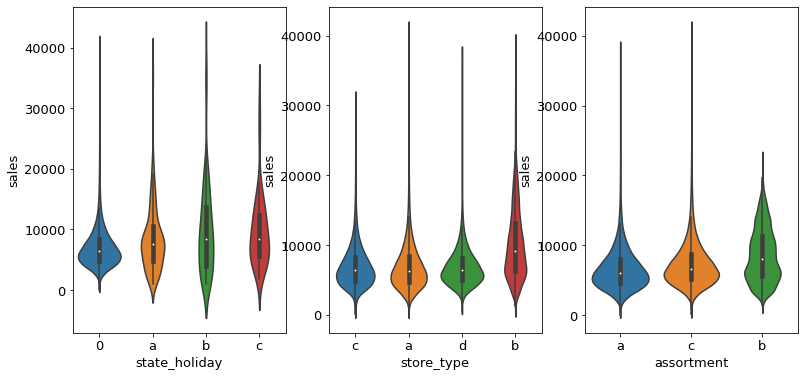

In [70]:
df_aux = df1[(df1["state_holiday"] != 0) & (df1["sales"] > 0)]

for i in zip( range(1, 4), ["state_holiday", "store_type", "assortment"] ):
    plt.subplot( 1, 3, i[0] )
    sns.violinplot( x=i[1], y='sales', data=df_aux )

# 2.0. Feature Engineering

## 2.1. Mind Map

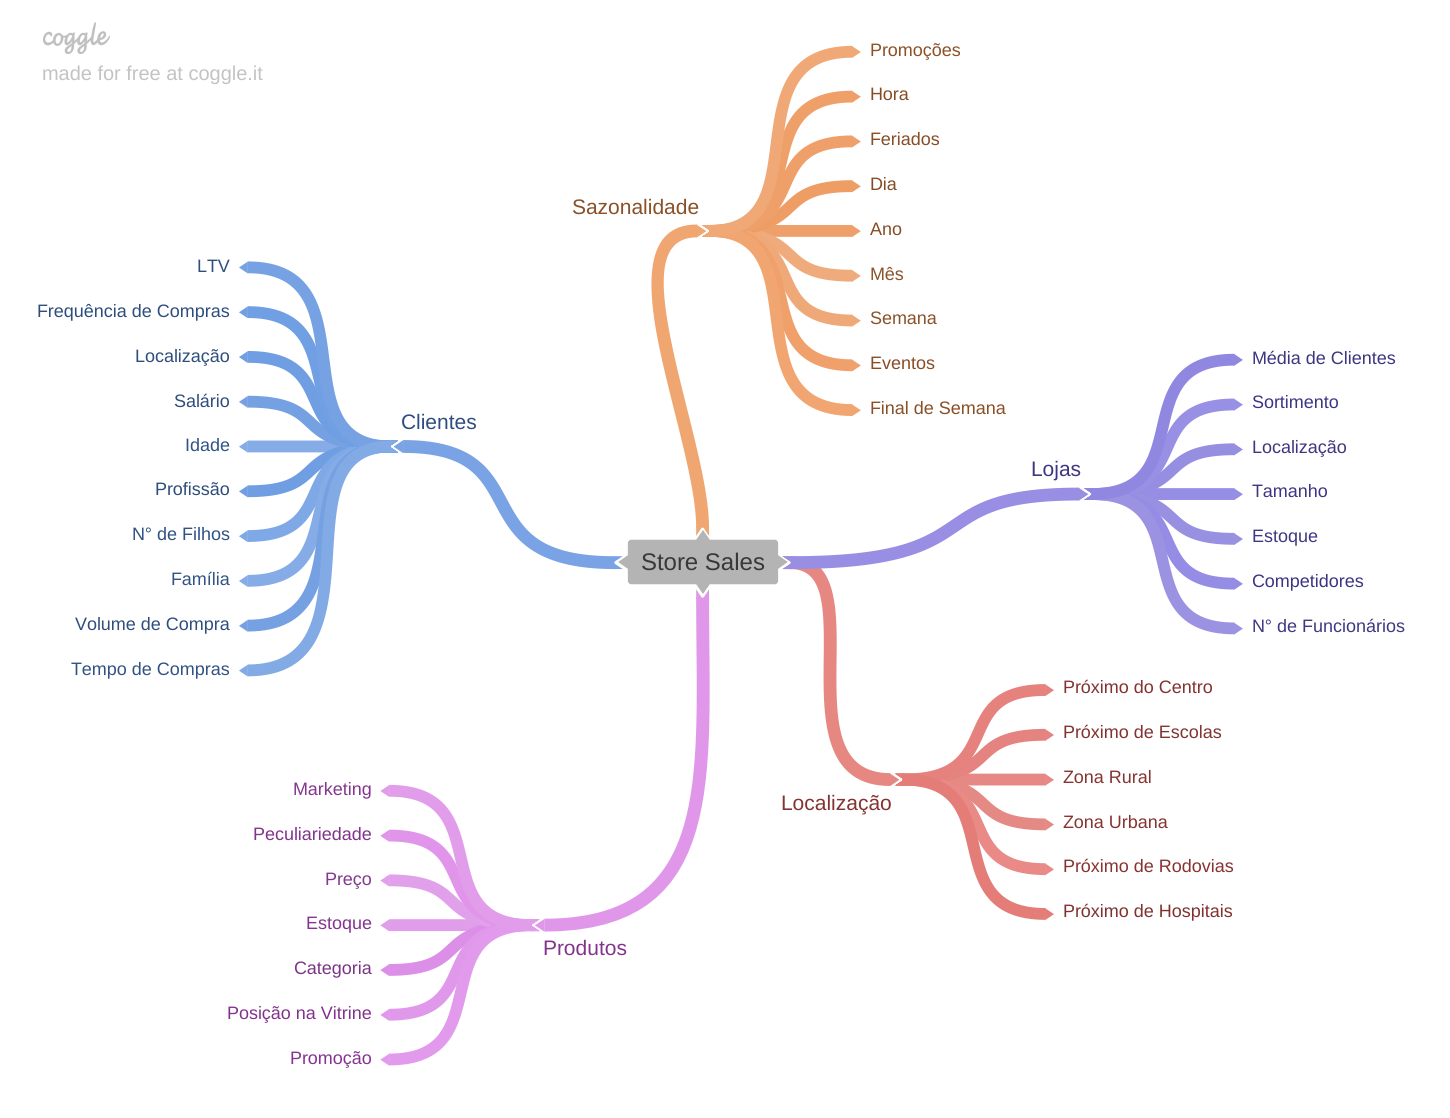

In [79]:
Image('../img/mind.png')

## 2.2. Hypothesis List

### 2.2.1. Shop Hypothesis

**1.** Lojas com maior quadro de funcionários deverian vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2. Product Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem um preço menor deveriam vender mais.

**4.** Lojas que tem mais variedades de produtos deveriam vender mais.

### 2.2.3. Time Hypothesis

**1.** Lojas que abrem em feriados natalinos deveriam vender mais.

**2.** Lojas que abrem no finla de semana deveriam vender mais.

**3.** Lojas que entram mais em feriados deveriam vender menos.

### 2.2.4. Final Hypothesis List

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**4.** Lojas com competidores a mais tempo deveriam vender mais.

**5.** Lojas com promoções ativas a mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos nos finais de semana.

**13.** Lojas deveriam vender menos nos feriados escolares.

## 2.3. Feature Engineering

In [21]:
df2 = df1.copy()

In [22]:
# Year
df2['year'] = df2["date"].dt.year

# Month
df2['month'] = df2["date"].dt.month

# Week of Year
df2['week_of_year'] = df2["date"].dt.weekofyear

# Year Week
df2['year_week'] = df2["date"].dt.strftime( '%Y-%W' )

# Day
df2["day"] = df2['date'].dt.day

# Competition Since
df2["competition_since"] = df2.apply( lambda x: datetime.datetime( year=x["competition_open_since_year"], 
                                                                   month=x["competition_open_since_month"], day=1), axis=1 )

# Competition Time Month
df2['competition_time_month'] = ((df2["date"] - df2["competition_since"] )/ 30).apply( lambda x: x.days ).astype('int64')

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2["promo_since"].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) if x != '0-0' else x.replace('0-0', '0') )
df2['promo_time_week'] = ((df2['date'] - df2[~pd.notnull(df2['promo_since'].str.contains('0-0'))]['promo_since'])/7).apply( lambda x: x.days ).fillna(0).astype('int64')

# Assortment
df2['assortment'] = df2["assortment"].map({"a":"basic", "b":"extra", "c":"extended"})

# State Holiday
df2['state_holiday'] = df2['state_holiday'].map({'a':'public_holiday', 'b':'easter_holiday', 'c':'christmas', '0':'regular_day'})

# 3.0. Data Filtering

In [23]:
df3 = df2.copy()

## 3.1.  Row Features

In [30]:
df3[(df3['open'] == 0) & (df3['sales'] > 0)]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,week_of_year,year_week,day,competition_since,competition_time_month,promo_since,promo_time_week


In [32]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2.  Columns Selection

In [33]:
df3 = df3.drop( ['customers', 'open', 'month_map', 'promo_interval'], axis=1 )
df3 = df3.reset_index( drop=True )

df3.to_csv("../data_backup/df3.csv")

# 4.0. Exploratory Data Analysis

In [34]:
df4 = df3.copy()

## 4.1. Univariable Analysis

### 4.1.1. Response Variable

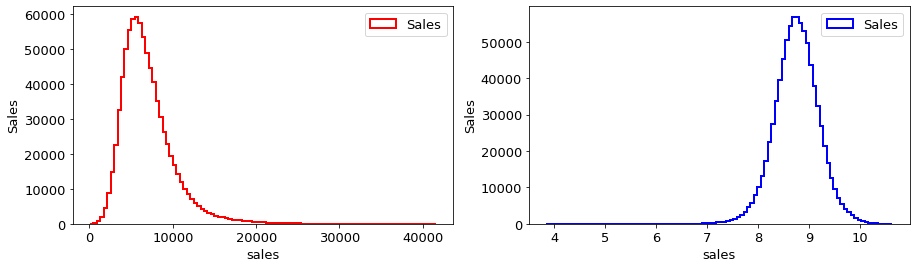

In [58]:
plot_target( [df4['sales'], np.log1p( df4['sales'] )], 'Sales' );

### 4.1.2. Numerical Variable

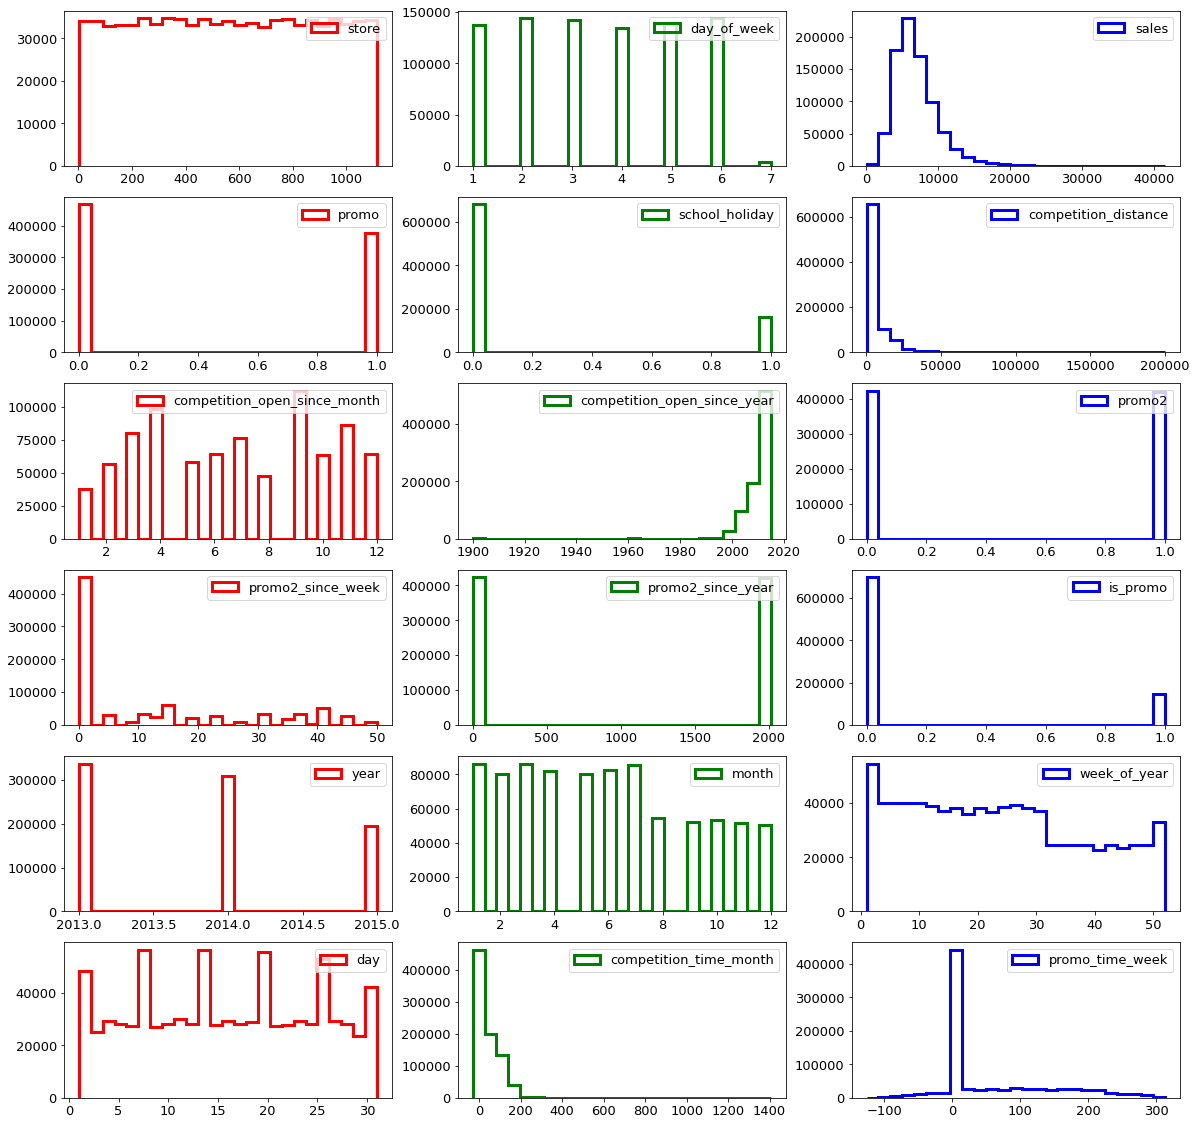

In [161]:
num_att, catt_att = metrics( df4 )
plot_num_att( num_att, num_att.columns.tolist() )

### 4.1.3. Categorical Variable

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


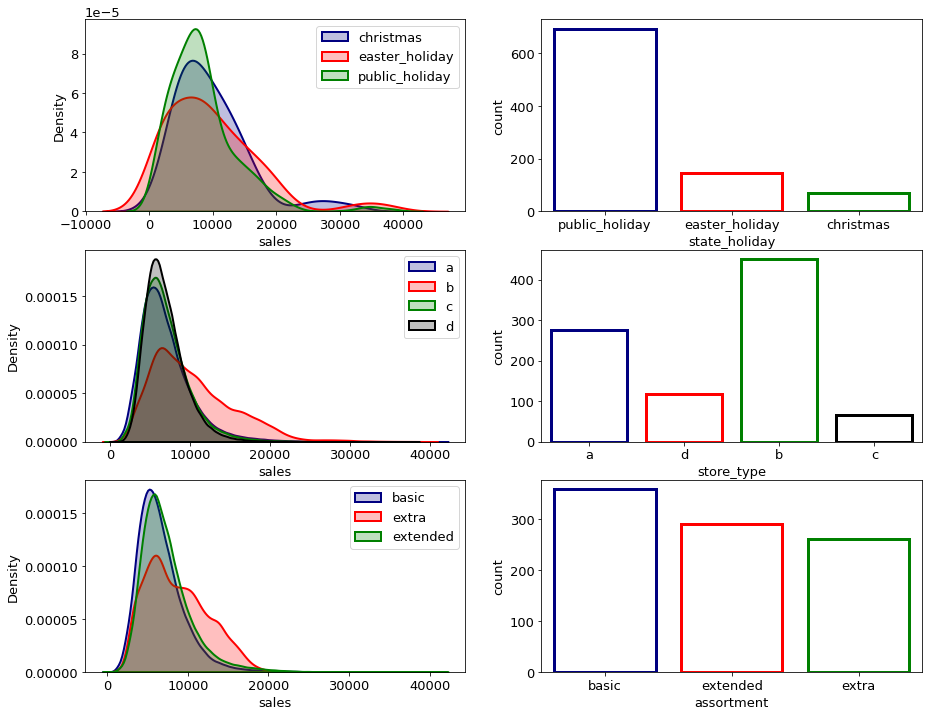

In [415]:
color = ['navy', 'r', 'g', 'k']

plot_categorical( df4, color );

## 4.2. Bivariable Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais.
- Assumindo Extra como a maior a hipótese é **Falsa**

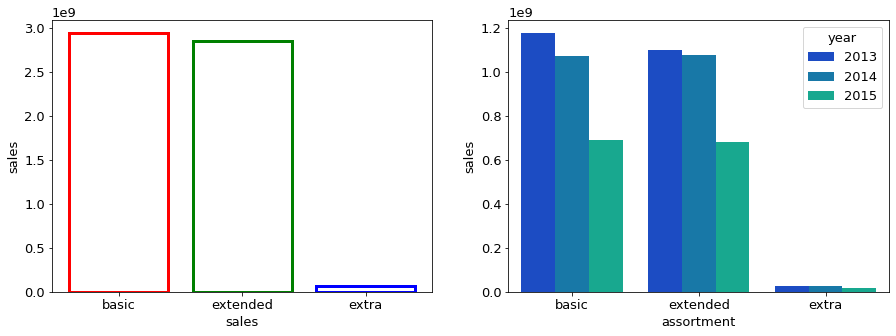

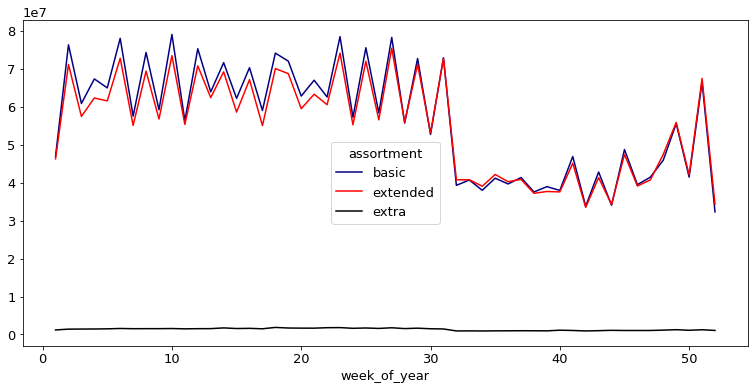

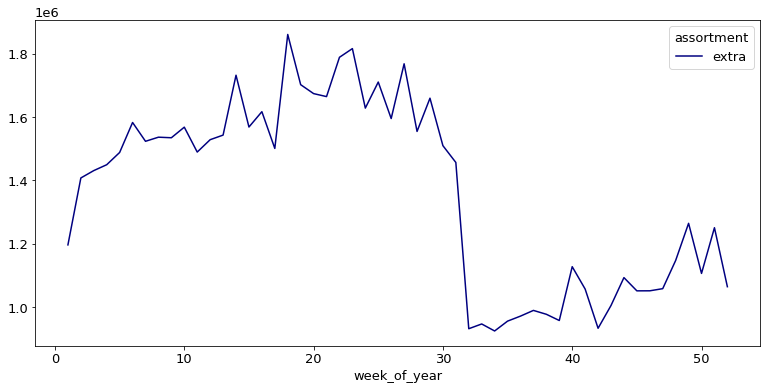

In [524]:
aux0 = df4[['assortment', 'sales']].groupby('assortment').sum()
aux1 = df4[['year', 'assortment', 'sales']].groupby( ['assortment', 'year'] ).sum().reset_index()
aux2 = df4[['week_of_year', 'assortment', 'sales']].groupby( ['assortment', 'week_of_year'] ).sum().reset_index()
aux3 = aux2[aux2['assortment'] == 'extra']

plot_bar( aux0, 'sales' )
plot_bar( aux0, 'sales', 'assortment', hue='year' )

aux2.pivot( index='week_of_year', columns='assortment', values='sales' ).plot( color=['navy', 'r', 'k'] );
aux3.pivot( index='week_of_year', columns='assortment', values='sales' ).plot( color='navy');

Teste de Hipótese Anova.

In [87]:
anova_scipy( df4[df4['assortment'] == 'basic']['sales'], df4[df4['assortment'] == 'extended']['sales'],df4[df4['assortment'] == 'extra']['sales'] )

P-Valor: 0.0
Estatística F: 6302.467300859967


In [83]:
anova_stats( df4, 'sales ~ assortment' )

,sum_sq,df,F,PR(>F)
assortment,1.196459e+11,2.0,6302.467301,0.0
Residual,8.014419e+12,844335.0,NaN,NaN


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
- Análise do grafico responde a hipótese como **Falsa**

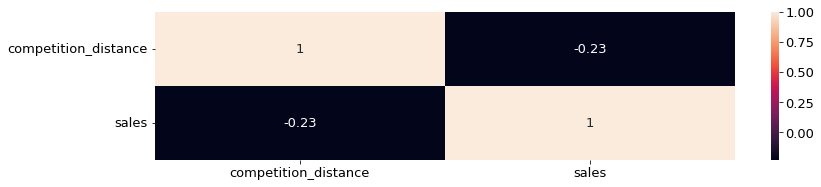

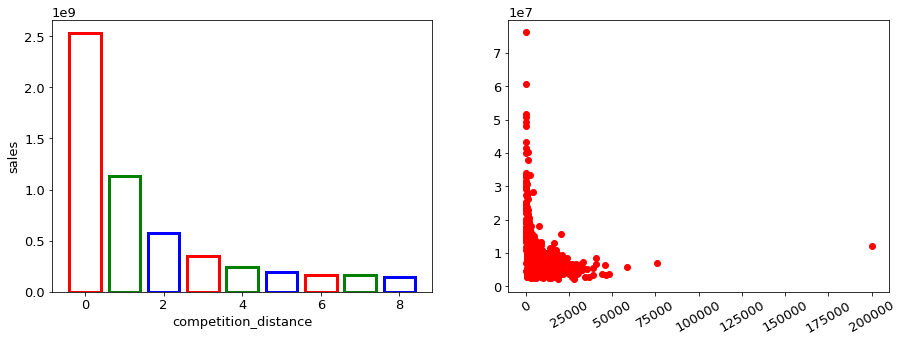

In [203]:
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux['competition_binned'] = pd.cut( df4['competition_distance'], bins=np.arange( 0, 20000, 2000 ) )
aux1 = aux[['competition_binned', 'sales']].groupby('competition_binned').sum().reset_index()
c = ['r', 'gold', 'b', 'k', 'm', 'navy']

plt.subplot( 2, 1, 1 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );
plot_bar( aux1, 'competition_binned', aux['competition_distance'], aux, xl='competition_distance', scatter=True )

### **H4.** Lojas com competidores a mais tempo deveriam vender mais.
- Quando mais proximo da abertura do competidor maior as vendas, logo a hipótese é **Falsa**

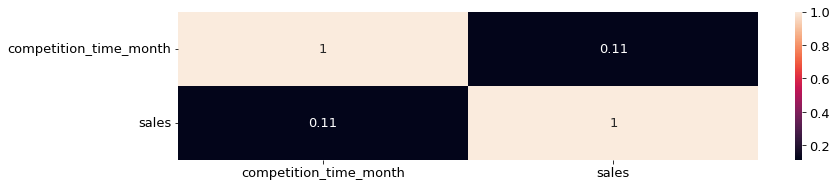

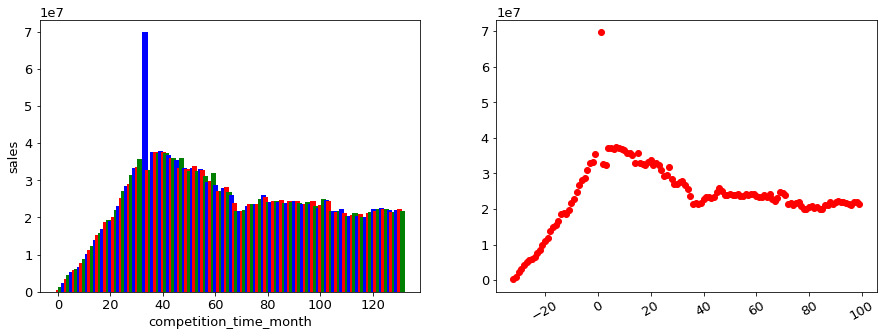

In [307]:
aux = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux = aux[(aux['competition_time_month'] < 100) & (aux['competition_time_month'] != 0)]

plt.subplot( 2, 1, 1 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );
plot_bar( aux, 'sales', 'competition_binned', aux['competition_time_month'], aux, xl='competition_time_month', scatter=True )

### **H5.** Lojas com promoções ativas a mais tempo deveriam vender mais.
- Dependendo da quantidade de dias de promoções extendidas, é um prejuizo para a loja, logo a hipótese é **Falsa**

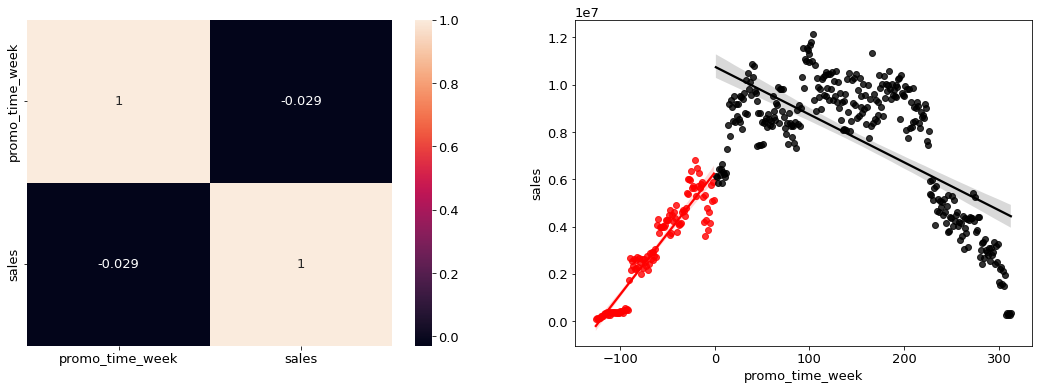

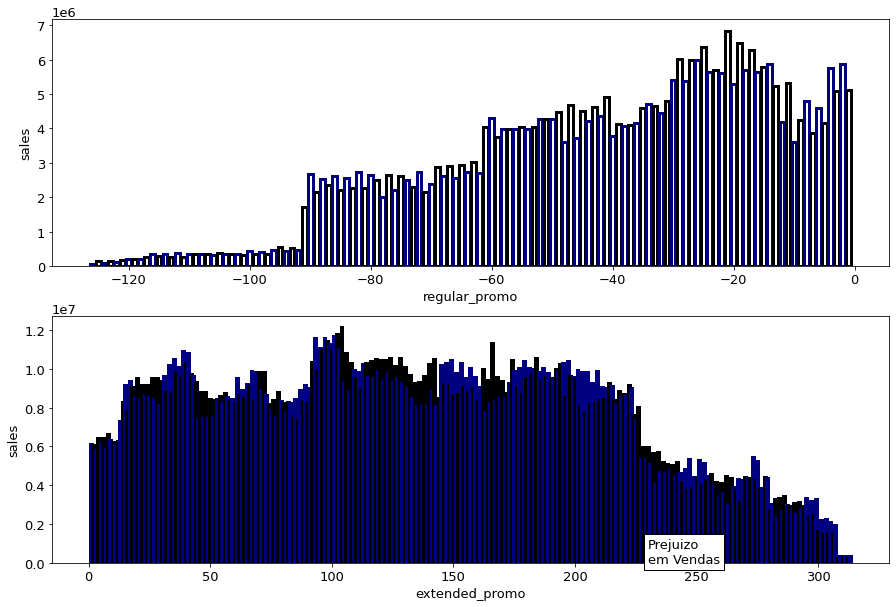

In [417]:
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux1 = aux[aux['promo_time_week'] < 0] # Regular Promo
aux2 = aux[aux['promo_time_week'] > 0] # Extended Promo

plt.subplot( 1, 2, 1 )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

plt.subplot( 1, 2, 2 )
ax = sns.regplot( aux1['promo_time_week'], aux1['sales'], color='r' )
ax = sns.regplot( aux2['promo_time_week'], aux2['sales'], color='k' )

progression_bar( aux1, aux2, 'sales', 'promo_time_week', 'regular_promo', 'extended_promo', text_dims0=230, text_dims1=3*100 )

###  <s>**H6.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
- Falsa, de acordo com os gráficos e o teste de hipóteses.

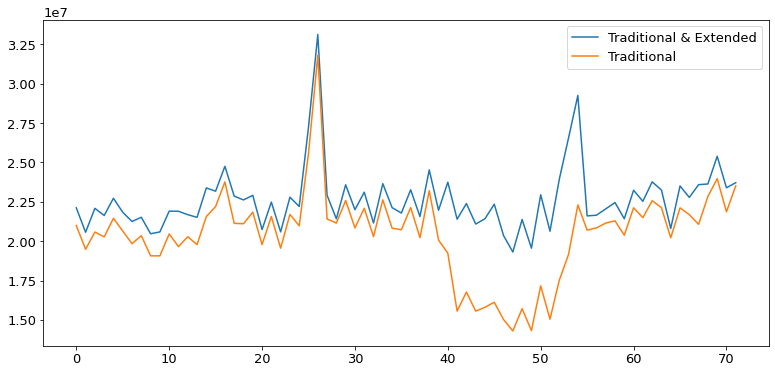

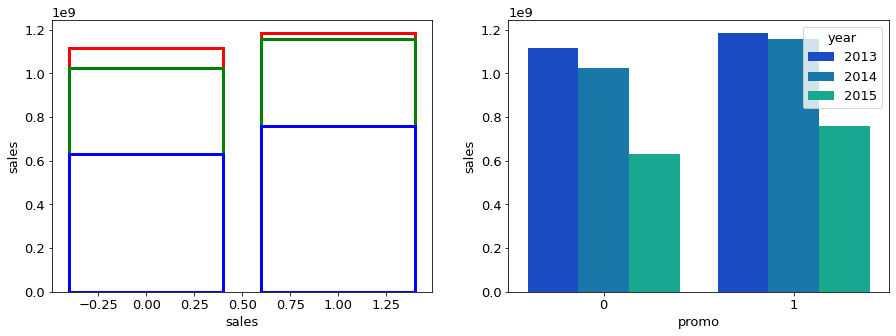

In [494]:
aux1 = df4[['promo', 'sales', 'year']].groupby( ['promo', 'year'] ).sum().reset_index()

trad = df4[( df4['promo']==1 ) & ( df4['promo2']==0 )][['sales', 'year_week']]
trad_extended = df4[( df4['promo']==1 ) & ( df4['promo2']==1 )][['sales', 'year_week']]

ax = trad.groupby( ['year_week'] ).sum().reset_index().plot()
trad_extended.groupby( ['year_week'] ).sum().reset_index().plot( ax=ax )
ax.legend( labels=['Traditional & Extended', 'Traditional'] )

plot_bar( aux1, 'promo', hue='year', xl='promo' )

### **H8.** Lojas abertas durante o feriado de natal deveriam vender mais.
- De acordo com os gráficos, nem o dado do ano de 2015 temos armazenado, poderia fazer uma previsão para esses dados ou coletar eles, logo a hipótese é **Verdadeira** (Em relação a 2013 - 2014), pois as lojas vendem mais acada ano nos feriados de natal, mas em relação a outras variáveis não vende mais.

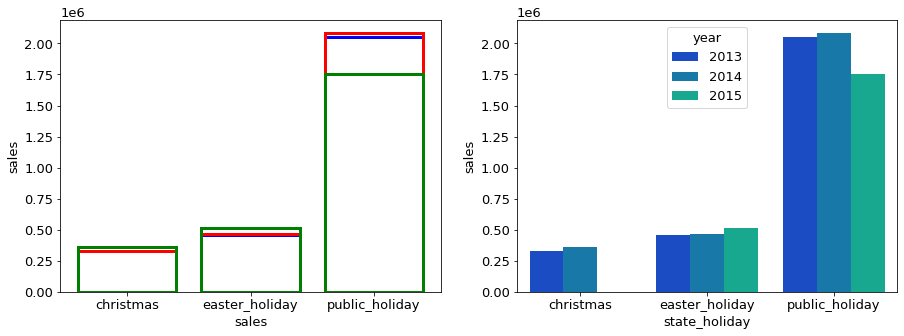

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales', 'year']].groupby(['state_holiday', 'year']).sum().reset_index()

plot_bar( aux1, 'state_holiday', xl='state_holiday', hue='year' )

In [85]:
anova_scipy( df4[df4['state_holiday'] == 'christmas']['sales'], df4[df4['state_holiday'] == 'easter_holiday']['sales'],df4[df4['state_holiday'] == 'public_holiday']['sales'] )

P-Valor: 0.01654142394072274
Estatística F: 4.120494254925124


In [86]:
anova_stats( df4, 'sales ~ state_holiday' )

,sum_sq,df,F,PR(>F)
state_holiday,3.429413e+09,3.0,118.710298,7.283351e-77
Residual,8.130635e+12,844334.0,NaN,NaN


### **H9.** Lojas deveriam vender mais ao longo dos anos.
- Como não temos todos os dados, apriori poderiamos dizer que realmente as lojas poderiam vender menos ao longo dos anos, mas como o ano de 2015 não esta concluido, pode ser que as vendas em 2015 aumentem, logo essa hipótese é **Verdadeira**

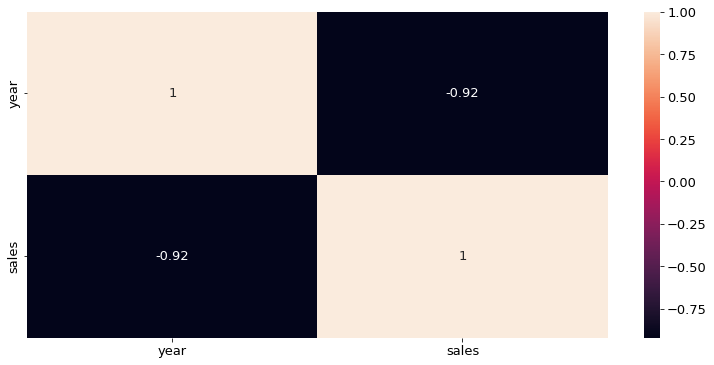

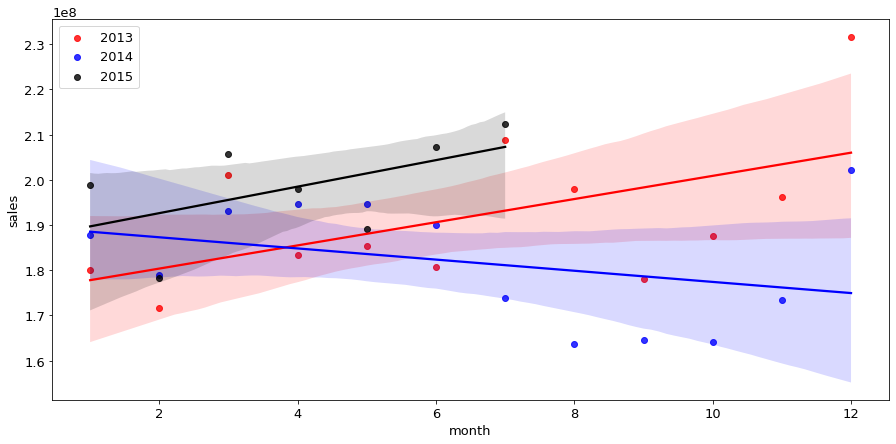

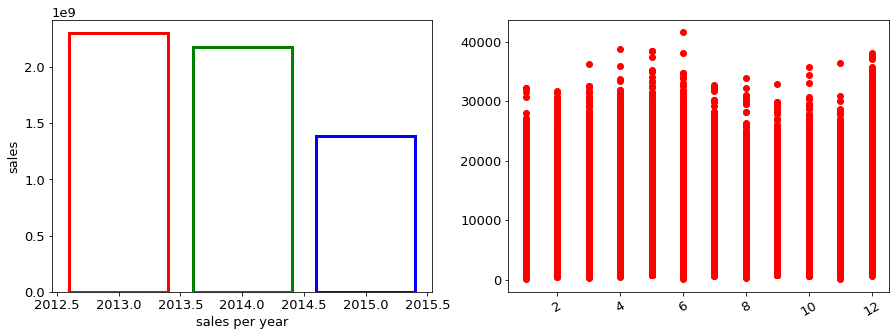

In [120]:
aux = df4[['sales', 'year']].groupby(['year']).sum().reset_index()

sns.heatmap( aux.corr( method='pearson' ), annot=True );

fig, ax = plt.subplots( figsize=(15, 7) )
for i in zip( [df4[df4['year'] == 2013], df4[df4['year'] == 2014], df4[df4['year'] == 2015]], ['r', 'b', 'k'], ['2013', '2014', '2015']):
    aux2 = i[0][['sales', 'month']].groupby('month').sum().reset_index()
    ax = sns.regplot( aux2['month'], aux2['sales'], color=i[1], label=i[2] )
    ax.legend()
    
plot_bar( aux, 'year', xl='sales per year', scatter=True, df_scatter_x=df4['month'], df_scatter_y=df4['sales'] )

### **H11**. Lojas deveriam vender mais depois do dia 10 de cada mês.
- Devido ao dobro do periodo não há uma comparação justa, logo é **Verdadeira**

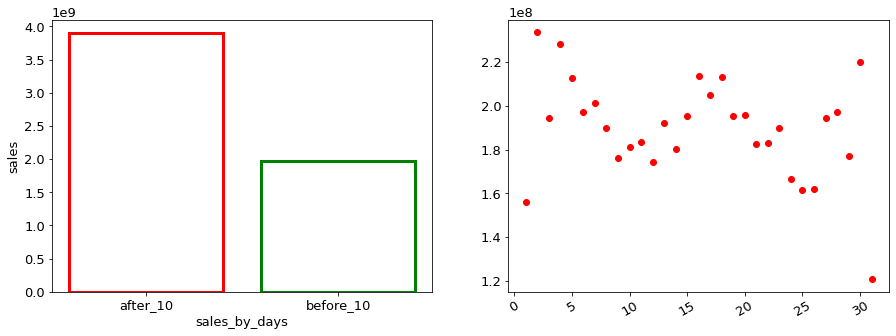

In [134]:
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux['before_10'] = aux['day'].apply( lambda x: 'before_10' if x <= 10 else 'after_10' )
aux1 = aux[['before_10', 'sales']].groupby('before_10').sum().reset_index()

plot_bar( aux1, 'before_10', xl='sales_by_days', scatter=True, df_scatter_x=aux['day'] , df_scatter_y=aux['sales'] )

### **H12**. Lojas deveriam vender menos nos finais de semana.
- Dado os gráficos, as lojas realmente vendem menos.

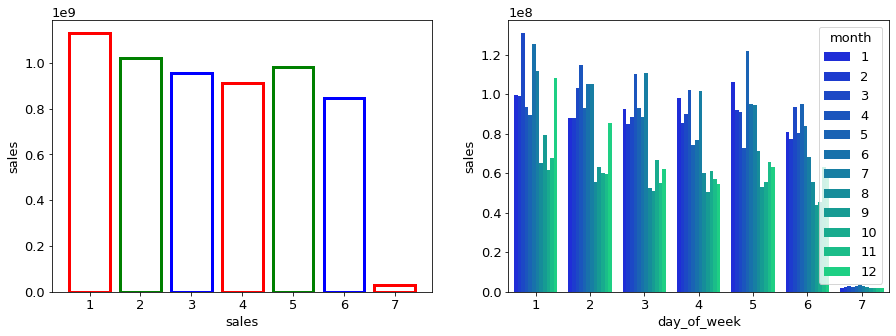

In [151]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
aux2 = df4[['day_of_week', 'month', 'sales']].groupby(['day_of_week', 'month']).sum().reset_index()

plot_bar( aux, 'day_of_week', xl='sales_by_days', hue='month', df_hue=aux2 )

### **H13**. Lojas deveriam vender menos nos feriados escolares. 
 - Em comparação com os demais meses e lembrando que não esta fechado o dataset, logo essa hipótese é **falsa**.

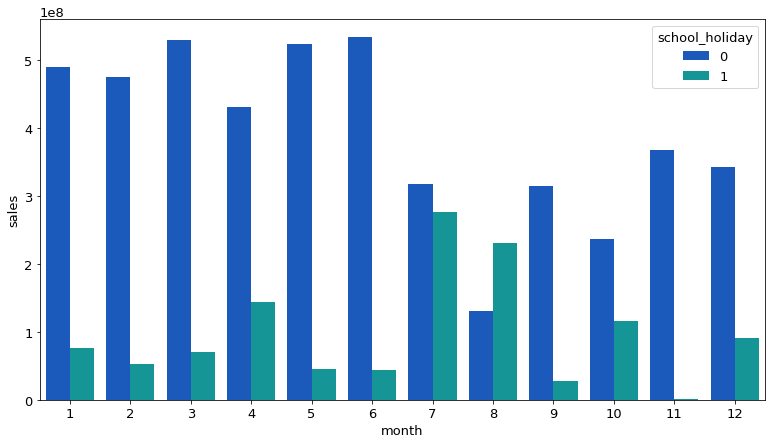

In [292]:
aux = df4[['school_holiday', 'sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()

fig, ax = plt.subplots( figsize=(13, 7) )
ax = sns.barplot( aux['month'], aux['sales'], hue=aux['school_holiday'], palette='winter')

## 4.3. Multivariable Analysis

In [316]:
num_att, catt_att = mp.metrics( df4 )

### 4.3.1. Numerical Attributes

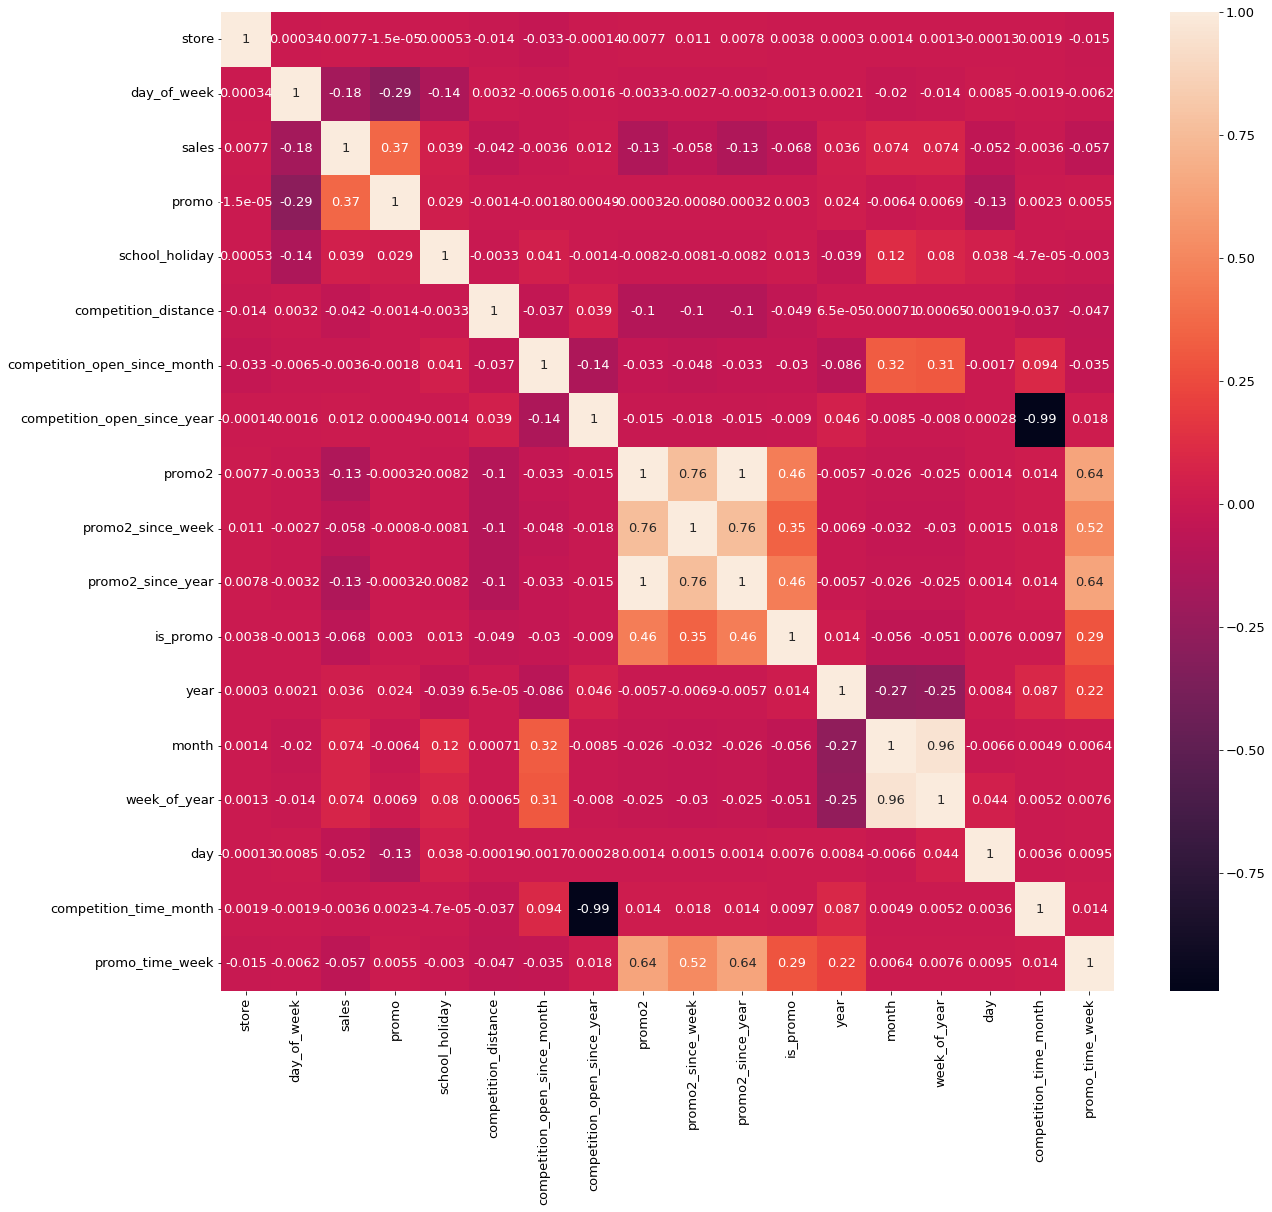

In [312]:
plt.rcParams['figure.figsize'] = [20, 18]
sns.heatmap( num_att.corr( method='pearson' ), annot=True );

### 4.3.2. Categorical Attributes

In [327]:
a = catt_att.iloc[:, :-2]

cols = []
for i in a.columns.tolist():
    for j in a.columns.tolist():
        a1 = cramer_v( a[i], a[j] )
        cols.append(a1)
        
d = pd.DataFrame( {'state_holiday': cols[0:3], 'store_type': cols[3:6], 'assortment': cols[6:9]} )
d = d.set_index( d.columns )

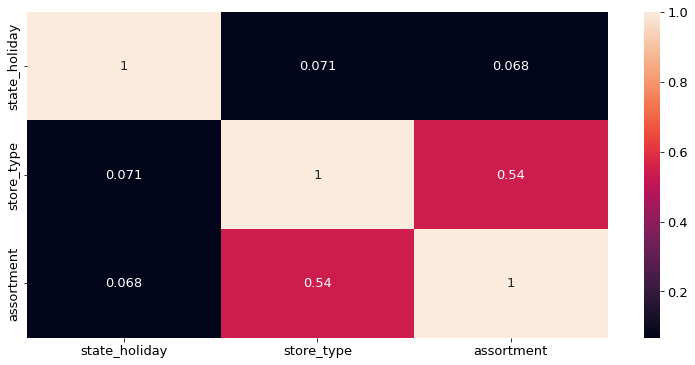

In [380]:
sns.heatmap( d, annot=True );